Author: Carlos Roberto de Melo
    
Date: 07/11/2020

Obj: Parametrizar o perfil pseudo-NFW apresentado em Collett et al. 2018. A parametrização é feita com gaussianas, de modo que possam ser adicionadas ao potencial do JAM mais tarde.

In [1]:
from mgefit import mge_fit_1d
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u



In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#NFW parameters
critical_density = (D_s*c_Mpc**2)/(4*np.pi*G_Mpc*D_ls*D_l) #Critical density in M_sun/Mpc²



theta_einstein_arc = 1.21*u.arcsecond
theta_einstein_rad = theta_einstein_arc.to(u.rad)
theta_einstein_pc = (theta_einstein_arc*D_l).to(u.pc, u.dimensionless_angles())

mass_inside = (D_l*D_s/D_ls)*(c_Mpc**2/(4*np.pi*G_Mpc))*(theta_einstein_rad.value**2)
Re_arc = 0.7*u.arcsecond
Re_pc = (Re_arc*D_l).to(u.pc, u.dimensionless_angles())

rho0 = 10.86746*(u.solMass/u.pc**3)
theta_einstein_pc

<Quantity 870.7672368 pc>

In [34]:
#Definindo algumas funções úteis.
SQRT_TOW_PI = np.sqrt(2*np.pi)


#Perfil Exponential
def exp(rho_0, Re, R):
        #rho_0: float in units of M_sun/pc³
        #Re: float in units of pc
        #R: array in units of pc
    rho = rho_0*np.exp(-R/Re)
    return rho

#Realializa a deprojeção de 2d para 3d das gaussianas. Isso assume uma certa parametrização mge2d, um ângulo
    #de inclinação para deprojeção e um formato (oblate ou prolate)
def deprojection(mge2d, inc, shape):
        '''
        Return the 3D deprojected MGE coefficients
        '''
        mge3d = np.zeros_like(mge2d)
        if shape == 'oblate':
            qintr = mge2d[:, 2]**2 - np.cos(inc)**2
            if np.any(qintr <= 0):
                raise RuntimeError('Inclination too low q < 0')
            qintr = np.sqrt(qintr)/np.sin(inc)
            if np.any(qintr < 0.05):
                raise RuntimeError('q < 0.05 components')
            dens = mge2d[:, 0]*mge2d[:, 2] /\
                (mge2d[:, 1]*qintr*SQRT_TOW_PI)
            mge3d[:, 0] = dens
            mge3d[:, 1] = mge2d[:, 1]
            mge3d[:, 2] = qintr
        elif shape == 'prolate':
            qintr = np.sqrt(1.0/mge2d[:, 2]**2 -
                            np.cos(inc)**2)/np.sin(inc)
            if np.any(qintr > 10):
                raise RuntimeError('q > 10.0 conponents')
            sigmaintr = mge2d[:, 1]*mge2d[:, 2]
            dens = mge2d[:, 0] / (SQRT_TOW_PI*mge2d[:, 1] *
                                       mge2d[:, 2]**2*qintr)
            mge3d[:, 0] = dens
            mge3d[:, 1] = sigmaintr
            mge3d[:, 2] = qintr
        return mge3d


#Calcula a densidade luminosa de gaussianadas 3d para algum raio R
def luminosityDensity(mge3d, R, z):
        '''
        Return the luminosity density at coordinate R, z (in L_solar/pc^3)
        '''
        rst = 0.0
        ngauss = mge3d.shape[0]
        for i in range(ngauss):
            rst += mge3d[i, 0] * np.exp(-0.5/mge3d[i, 1]**2 *
                                        (R**2 + (z/mge3d[i, 2])**2))
        return rst

In [39]:
#Main code

r = np.logspace(np.log10(0.1), np.log10(1000), 1500) #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit). Unidade de pc
logr = np.log10(r)#Unidade de pc

#Definindo os parâmetros do Exponencial
R_e = Re_pc.value    #rs do modelo, fixado pelo paper [pc]
rho_0 = rho0.value  # [M_solar/pc³]  Obs:(1[M_solar/kpc^3] = 1e9[M_solar/pc^3])


#Calculando o perfil Exponencial analítico e tomando o log para posterior plot
mass_profile = np.log10(exp(rho_0=rho_0, Re=R_e, R=r)) 

#Agora vamos realizar a parametrização em MGE 1d
r_mge2d = np.logspace(np.log10(0.1), np.log10(1000), 1500) #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit)
rho_mge2d = exp(rho_0=rho_0, Re=R_e, R=r_mge2d) #Perfil Exponencial

#-------------Aqui é onde realmente começa a parametrização MGE--------------------------------

mge = mge_fit_1d.mge_fit_1d(r_mge2d, rho_mge2d, quiet=True, ngauss=100)
mge_peak = mge.sol[0]         #Pico de cada gaussiana
mge_sigma = mge.sol[1]        #Sigma de cada gaussiana
#O resultado acima já está em M_sun/pc²

mge2d = np.zeros((len(mge_peak), 3)) #Agora iremos criar um array com o número de linhas igual ao número de
                                        #gaussianas e três colunas para armazenar os dados
mge2d[:, 0] = mge_peak     #Pico de cada gaussiana
mge2d[:, 1] = mge_sigma    #Sigma de cada gausiana
mge2d[:, 2] = 1         #qObs de cada gaussiana. 

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


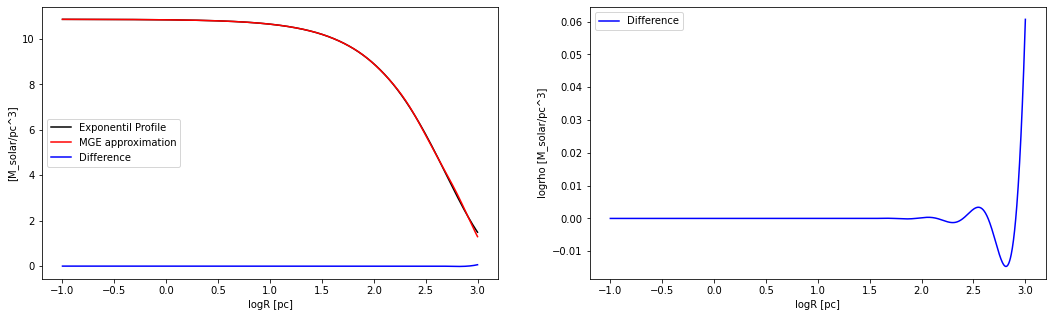

In [40]:
#--------------A partir daqui vamos apenas comparar o perfil analítico com o perfil parametrizado. Em princípio
    #o necessário para o modelo JAM termina acima e só é necessário salvar os dados. ----------------------------#
#Here are some unit conversion
mge3d = deprojection(mge2d=mge2d, inc=np.pi/2, shape='oblate' )#Deprojeta o perfil 2d para 3d assumindo uma inclinação inc e um formato do elipsoide de velocidades 
mge_density = luminosityDensity(mge3d,r,0) #Densidade das MGE deprojetadas. Atenção as unidades de medida.

#Finalmente o perfil DM parametrizado pelo MGE.
profile_mge = np.log10(mge_density)#Aqui voltamos a multiplicar por 1e9 pois queremos comparar com o outro perfil, que tem unidades [M_sol/pc³]

# plot the density profile of the dark halo and the mge approximation

plt.figure(figsize=(18,5))
plt.subplot(121)
line_dh, = plt.plot(logr, 10**mass_profile, 'k')
line_mge, = plt.plot(logr, 10**profile_mge, 'r')
diff, = plt.plot(logr, mass_profile-profile_mge, 'b', scalex=200)
plt.xlabel('logR [pc]')
plt.ylabel('[M_solar/pc^3]')
plt.legend([line_dh, line_mge, diff], ['Exponentil Profile', 'MGE approximation', 'Difference'])


plt.subplot(122)
diff, = plt.plot(logr, mass_profile-profile_mge, 'b', scalex=200)
plt.xlabel('logR [pc]')
plt.ylabel('logrho [M_solar/pc^3]')
plt.legend([diff], ['Difference'])

plt.subplots_adjust(wspace=0.2)
plt.savefig('Exponential.png', fmt='png')

plt.show()


In [41]:
np.savetxt('Exponential.txt', np.column_stack([mge2d[:, 0], mge2d[:,1]/(D_l.value*np.pi/0.648),mge2d[:,2]]),
                            fmt=b'%10.6f\t\t\t %e\t\t %10.6f', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')

#Aqui, quando salvamos o sigma de cada gaussiana dividimos pelo valor (D_l*np.pi/0.648) pois o JAM requer 
    #que o sigma seja dado em arcsec. Nesta expressão D_l é a distância da galáxia em Mpc

In [42]:
mge2d/(D_l.value*np.pi/0.648)

array([[2.30935778e-07, 1.04240608e-04, 1.38957915e-03],
       [1.15161911e-07, 1.61259676e-04, 1.38957915e-03],
       [6.78565813e-07, 2.11292659e-04, 1.38957915e-03],
       [1.32392926e-06, 3.31498931e-04, 1.38957915e-03],
       [1.93840502e-06, 4.75291784e-04, 1.38957915e-03],
       [2.70510348e-06, 5.69114164e-04, 1.38957915e-03],
       [1.43026415e-05, 9.06300824e-04, 1.38957915e-03],
       [9.94052324e-06, 1.53290194e-03, 1.38957915e-03],
       [4.28481435e-05, 1.67738953e-03, 1.38957915e-03],
       [5.46666810e-06, 2.87972615e-03, 1.38957915e-03],
       [1.99902455e-04, 3.15116199e-03, 1.38957915e-03],
       [1.70269537e-04, 5.91980761e-03, 1.38957915e-03],
       [7.61765538e-04, 6.47779347e-03, 1.38957915e-03],
       [2.48952913e-03, 1.33163233e-02, 1.38957915e-03],
       [2.43386325e-03, 1.45714562e-02, 1.38957915e-03],
       [3.00781044e-02, 3.27777847e-02, 1.38957915e-03],
       [2.70590251e-02, 7.72777275e-02, 1.38957915e-03],
       [2.09555512e-01, 8.76158

In [76]:
r = np.logspace(-2.5, 2, 10)
r

array([3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00, 1.00000000e+01,
       3.16227766e+01, 1.00000000e+02])